In [824]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

In [826]:
def get_price_data(tickers, start):
    data = yf.download(tickers, start=start)["Close"]
    return data.dropna()

def compute_Nyear_metrics(prices, LOOKBACK_YEARS):
    n_days = 252 * LOOKBACK_YEARS
    rolling_returns = prices.shift(-n_days) / prices - 1
    annualized_returns = (1 + rolling_returns) ** (1 / LOOKBACK_YEARS) - 1
    mean_returns = annualized_returns.mean()
    
    drawdowns = prices / prices.cummax() - 1
    rolling_mdds = drawdowns.rolling(n_days, min_periods=1).min()
    min_mdds = rolling_mdds.min()
    
    return rolling_returns, rolling_mdds, mean_returns, min_mdds

TICKERS = ['BTC-USD','ETH-USD']
START_DATE = '2010-01-01'
price_data = get_price_data(TICKERS, START_DATE)
price_data.columns = [col.replace('-','_') for col in price_data.columns]
common_start = '2018-01-01'
price = price_data[price_data.index >= common_start]

[*********************100%***********************]  2 of 2 completed


### Dollar hedge portolio

In [829]:
## dollar hedge portfolio with no rebalancing
# how many ETH perp contracts to short initially to dollar-hedge 1 BTC
dollar_hedge_pf = price.copy().reset_index()
dollar_hedge_pf['month'] = dollar_hedge_pf['Date'].dt.strftime('%Y-%m')
dollar_hedge_pf['dollarHR'] = dollar_hedge_pf.BTC_USD / dollar_hedge_pf.ETH_USD

## dollar hedge portfolio with Beginning of Month rebalancing
BOM_rebalancing = (
    dollar_hedge_pf.reset_index()
    .groupby(['month'])[['Date','dollarHR']].first()
    .reset_index()
    .rename(columns={'dollarHR':'dollarHR_BOM'})
)[['Date','dollarHR_BOM']]

dollar_hedge_pf = dollar_hedge_pf.merge(BOM_rebalancing, how='left', on='Date').ffill()


# calculate hedged portfolio values
dollar_hedge_pf['dollar_hedged_pf_NR'] = dollar_hedge_pf.BTC_USD + (dollar_hedge_pf.ETH_USD * -1 * dollar_hedge_pf['dollarHR'].iloc[0])
dollar_hedge_pf['dollar_hedged_pf_MR'] = dollar_hedge_pf.BTC_USD + (dollar_hedge_pf.ETH_USD * -1 * dollar_hedge_pf['dollarHR_BOM'])
dollar_hedge_pf['dollar_hedged_pf_DR'] = dollar_hedge_pf.BTC_USD + (dollar_hedge_pf.ETH_USD * -1 * dollar_hedge_pf['dollarHR'])

### Beta hedge portolio

In [832]:
def static_reg(returns, y_asset, X_factors):
    returns = returns[[y_asset] + X_factors].dropna()
    X = returns[X_factors]
    y = returns[y_asset]
    model = sm.OLS(y, sm.add_constant(X)).fit()
    
    return model

def rolling_reg(returns, y_asset, X_factors, window):
    returns = returns[[y_asset] + X_factors].dropna()
    X = returns[X_factors]
    y = returns[y_asset]
    model = RollingOLS(y, sm.add_constant(X), window=window, min_nobs=window).fit()
    
    return model

estimation_period = 30
estimation_start = pd.Timestamp(common_start) - pd.offsets.BDay(estimation_period+1)
# 1 more observation to compensate for missing obs from returns calc
price = price_data[price_data.index >= estimation_start]
returns = price.pct_change()[1:]
returns.columns = [col + '_ret' for col in returns.columns]

ols = static_reg(returns, y_asset='BTC_USD_ret', X_factors=['ETH_USD_ret'])
rols = rolling_reg(returns, y_asset='BTC_USD_ret', X_factors=['ETH_USD_ret'], window=estimation_period)

beta_hedge_pf = pd.concat([price, returns], axis=1)
beta_hedge_pf['ETH_ols_beta'] = beta_hedge_pf.BTC_USD * ols.params.ETH_USD_ret / beta_hedge_pf.ETH_USD
beta_hedge_pf['ETH_rols_beta'] = beta_hedge_pf.BTC_USD * rols.params.ETH_USD_ret / beta_hedge_pf.ETH_USD
beta_hedge_pf['month'] = beta_hedge_pf.index.strftime('%Y-%m')

## beta hedge portfolio with Beginning of Month rebalancing
BOM_rebalancing = (
    beta_hedge_pf.reset_index()
    .groupby(['month'])[['Date','ETH_rols_beta']].first()
    .reset_index()
    .rename(columns={'ETH_rols_beta':'ETH_rols_beta_BOM'})
)[['Date','ETH_rols_beta_BOM']]

beta_hedge_pf = beta_hedge_pf.merge(BOM_rebalancing, how='left', on='Date').ffill()
beta_hedge_pf = beta_hedge_pf[beta_hedge_pf.Date >= common_start]

# calculate hedged portfolio values
beta_hedge_pf['beta_hedged_pf_NR'] = beta_hedge_pf.BTC_USD + (beta_hedge_pf.ETH_USD * -1 * beta_hedge_pf['ETH_ols_beta'].iloc[0])
beta_hedge_pf['beta_hedged_pf_MR'] = beta_hedge_pf.BTC_USD + (beta_hedge_pf.ETH_USD * -1 * beta_hedge_pf['ETH_rols_beta_BOM'])
beta_hedge_pf['beta_hedged_pf_DR'] = beta_hedge_pf.BTC_USD + (beta_hedge_pf.ETH_USD * -1 * beta_hedge_pf['ETH_rols_beta'])

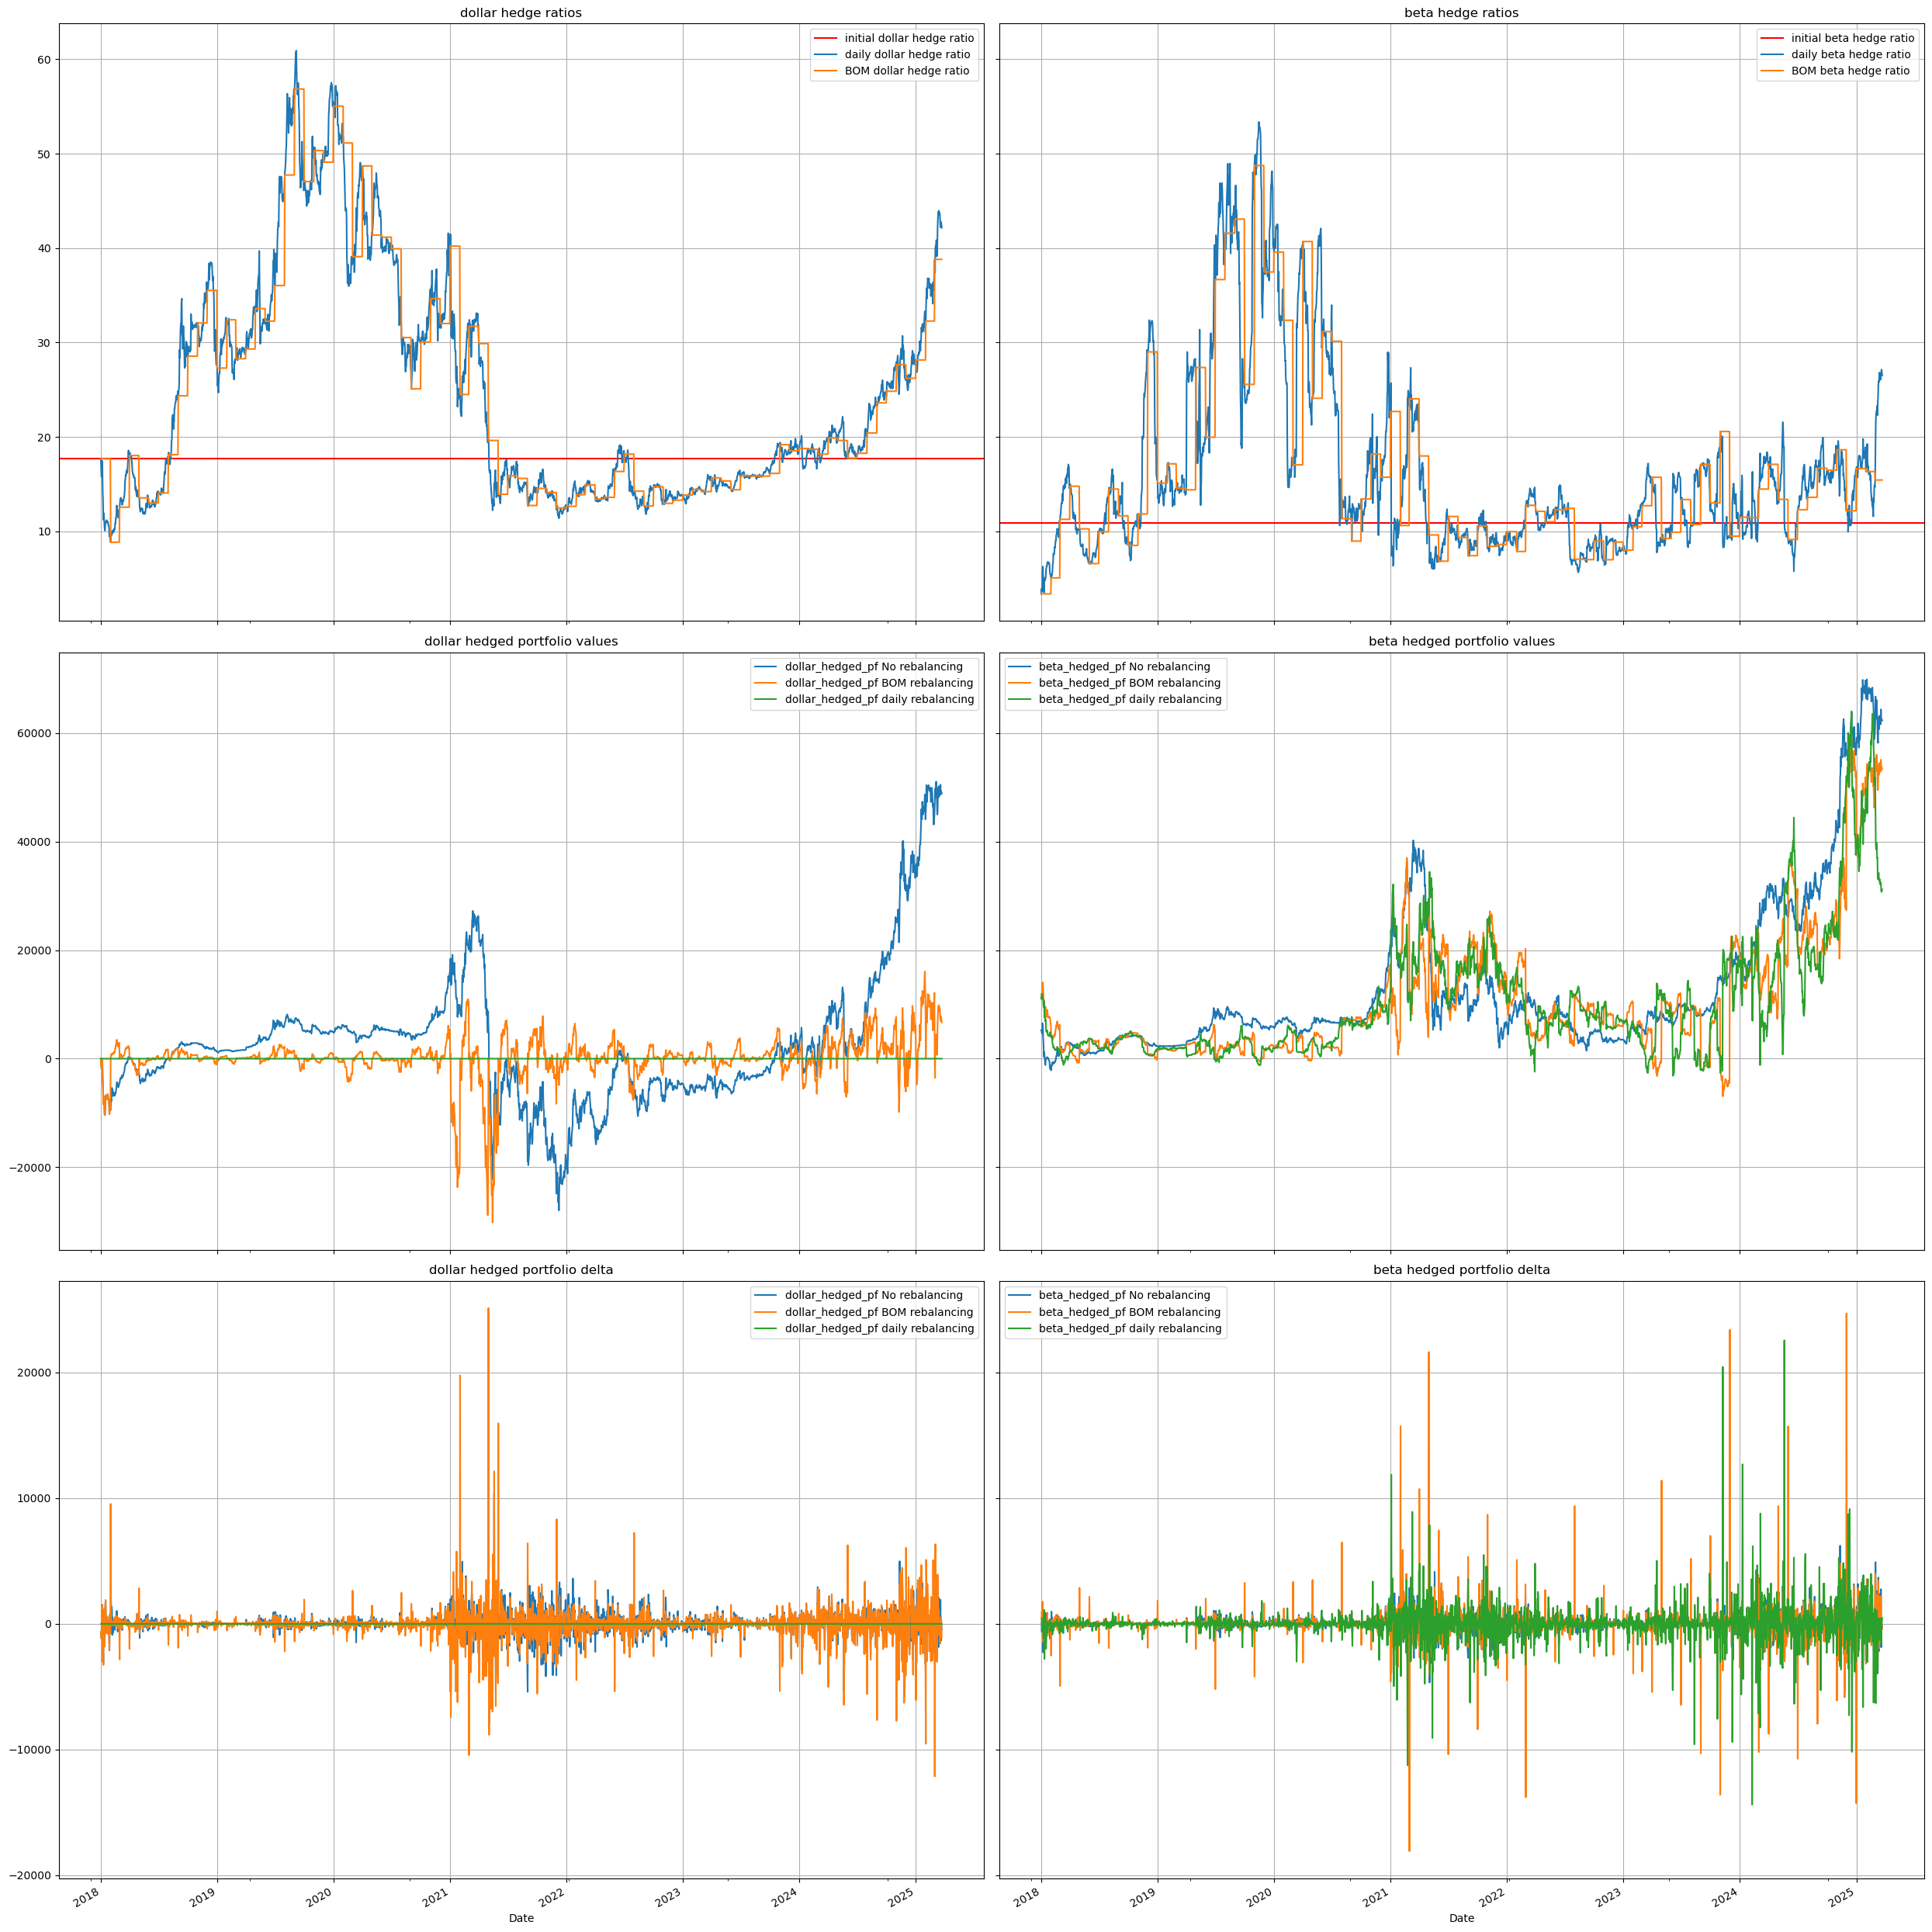

In [836]:
fig,ax = plt.subplots(3,2, figsize=(25,25), sharex=True, sharey='row')

ax[0,0].set_title('dollar hedge ratios')
ax[0,0].axhline(dollar_hedge_pf['dollarHR'].iloc[0], label='initial dollar hedge ratio', c='red')
dollar_hedge_pf.set_index('Date').dollarHR.plot(ax=ax[0,0], label='daily dollar hedge ratio')
dollar_hedge_pf.set_index('Date').dollarHR_BOM.plot(ax=ax[0,0], label='BOM dollar hedge ratio')

ax[1,0].set_title('dollar hedged portfolio values')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_NR'].plot(ax=ax[1,0], label='dollar_hedged_pf No rebalancing')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_MR'].plot(ax=ax[1,0], label='dollar_hedged_pf BOM rebalancing')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_DR'].plot(ax=ax[1,0], label='dollar_hedged_pf daily rebalancing')

ax[2,0].set_title('dollar hedged portfolio delta')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_NR'].diff().plot(ax=ax[2,0], label='dollar_hedged_pf No rebalancing')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_MR'].diff().plot(ax=ax[2,0], label='dollar_hedged_pf BOM rebalancing')
dollar_hedge_pf.set_index('Date')['dollar_hedged_pf_DR'].diff().plot(ax=ax[2,0], label='dollar_hedged_pf daily rebalancing')


ax[0,1].set_title('beta hedge ratios')
#ax[0].axhline(beta_hedge_pf['ETH_rols_beta'].iloc[0], label='initial dollar hedge ratio', c='red')
ax[0,1].axhline(beta_hedge_pf['ETH_ols_beta'].iloc[0], label='initial beta hedge ratio', c='red')
beta_hedge_pf.set_index('Date').ETH_rols_beta.plot(ax=ax[0,1], label='daily beta hedge ratio')
beta_hedge_pf.set_index('Date').ETH_rols_beta_BOM.plot(ax=ax[0,1], label='BOM beta hedge ratio')

ax[1,1].set_title('beta hedged portfolio values')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_NR'].plot(ax=ax[1,1], label='beta_hedged_pf No rebalancing')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_MR'].plot(ax=ax[1,1], label='beta_hedged_pf BOM rebalancing')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_DR'].plot(ax=ax[1,1], label='beta_hedged_pf daily rebalancing')

ax[2,1].set_title('beta hedged portfolio delta')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_NR'].diff().plot(ax=ax[2,1], label='beta_hedged_pf No rebalancing')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_MR'].diff().plot(ax=ax[2,1], label='beta_hedged_pf BOM rebalancing')
beta_hedge_pf.set_index('Date')['beta_hedged_pf_DR'].diff().plot(ax=ax[2,1], label='beta_hedged_pf daily rebalancing')

for i in range(3):
    for j in range(2):
        ax[i,j].legend()
        ax[i,j].grid()
plt.tight_layout();